In [1]:
from utils import *
from fcn import *
from keras.layers.merge import add
from keras.applications import vgg16

def FCN16s():
    inputData = Input(batch_shape=(None,224,224,3))
    #First Layer
    conv1_1 = Conv2D(64,kernel_size=(3,3),activation='relu',padding='same', name='conv1_1')(inputData)
    conv1_2 = Conv2D(64,kernel_size=(3,3),activation='relu',padding='same', name='conv1_2')(conv1_1)
    pool1 = MaxPooling2D((2,2), strides=(2,2), name='pool1')(conv1_2)
    #Second Convolution
    conv2_1 = Conv2D(128,kernel_size=(3,3),activation='relu',padding='same', name='conv2_1')(pool1)
    conv2_2 = Conv2D(128,kernel_size=(3,3),activation='relu',padding='same', name='conv2_2')(conv2_1)
    pool2 = MaxPooling2D((2,2), strides=(2,2), name='pool2')(conv2_2)
    #Third Convolution
    conv3_1 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same', name='conv3_1')(pool2)
    conv3_2 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same', name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same', name='conv3_3')(conv3_2)
    pool3 = MaxPooling2D((2,2), strides=(2,2), name='pool3')(conv3_3)
    #Fourth Convolution
    conv4_1 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv4_1')(pool3)
    conv4_2 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv4_3')(conv4_2)
    pool4 = MaxPooling2D((2,2), strides=(2,2), name='pool4')(conv4_3)
    #Fifth Convolution
    conv5_1 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv5_1')(pool4)
    conv5_2 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv5_3')(conv5_2)
    pool5 = MaxPooling2D((2,2), strides=(2,2), name='pool5')(conv5_3)
    #Fully Convolutional Layers 32s
    fc6 = Conv2D(4096,kernel_size=(7,7),activation='relu',padding='same', name='fc6')(pool5)
    drop6 = Dropout(0.5)(fc6)
    fc7 = Conv2D(4096,kernel_size=(1,1),activation='relu',padding='same', name='fc7')(drop6)
    drop7 = Dropout(0.5)(fc7)
    score_fr = Conv2D(21, kernel_size=(1,1), padding='valid', name='score_fr')(drop7)
    #Deconv Layer
    score2 = Conv2DTranspose(21, kernel_size=(4,4),strides=(2,2), name='score2')(score_fr)
    upscore2 = Cropping2D(cropping=1, name='crop')(score2)
    #Merge with 4th Convolution
    score_pool4 = Conv2D(21, kernel_size=(1,1), padding='valid', name='score_pool4')(pool4)
    fuse = add([upscore2,score_pool4], name='fuse')
    #Score
    upscore16 = Conv2DTranspose(21, kernel_size=(32,32),strides=(16,16), name='upsample_new')(fuse)
    score = Cropping2D(cropping=8, name='score')(upscore16)
    model = Model(inputs=inputData, outputs=[score])
    return model


Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


In [2]:
model = FCN16s()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 224, 224, 64)  36928       conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 112, 112, 64)  0           conv1_2[0][0]                    
___________________________________________________________________________________________

In [3]:
#from https://github.com/mzaradzki/neuralnets/tree/master/vgg_segmentation_keras
from scipy.io import loadmat

data = loadmat('pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description


def copy_mat_to_keras(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]
    for i in range(0, p.shape[1]-1, 2):
        matname = '_'.join(p[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print 'found : ', (str(matname), kindex)
            l_weights = p[0,i].value
            l_bias = p[0,i+1].value
            kmodel.layers[kindex].set_weights([l_weights, l_bias[:,0]])
        else:
            print 'not found : ', str(matname)


In [4]:
copy_mat_to_keras(model)

found :  ('conv1_1', 1)
found :  ('conv1_2', 2)
found :  ('conv2_1', 4)
found :  ('conv2_2', 5)
found :  ('conv3_1', 7)
found :  ('conv3_2', 8)
found :  ('conv3_3', 9)
found :  ('conv4_1', 11)
found :  ('conv4_2', 12)
found :  ('conv4_3', 13)
found :  ('conv5_1', 15)
found :  ('conv5_2', 16)
found :  ('conv5_3', 17)
found :  ('fc6', 19)
found :  ('fc7', 21)
found :  ('score_fr', 23)
found :  ('score2', 24)
found :  ('score_pool4', 26)
found :  ('upsample_new', 28)


/home/afagnani/miniconda2/lib/python2.7/site-packages/PIL/Image.py:885: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


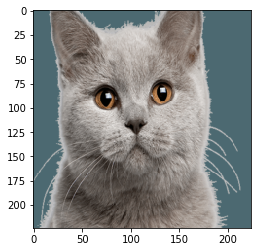

In [5]:
catorig = open_image('cat.png', resize=(224,224,3))
%matplotlib inline
plt.imshow(catorig)

In [6]:
def prepareim(im):
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = np.expand_dims(im, axis=0)
    return im

cat = catorig.astype('float64')
catp = prepareim(cat)

In [7]:
preds = model.predict(catp)
imclass = np.argmax(preds, axis=3)[0,:,:]

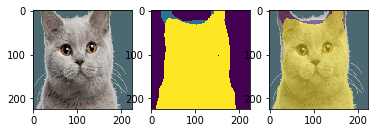

In [8]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(catorig)
plt.subplot(1,3,2)
plt.imshow(imclass)
plt.subplot(1,3,3)
plt.imshow(catorig)
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow(masked_imclass, alpha=0.5)

In [9]:
for c in np.unique(imclass):
    if c < 22:
        print c, str(description[0,c][0])
        

class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

0 background
3 bird
8 cat
['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


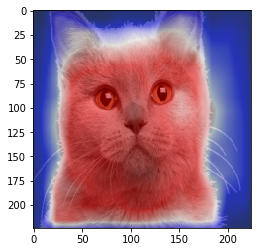

In [10]:
plt.imshow(catorig)
plt.imshow(preds[0,:,:,class2index['cat']], cmap='seismic', alpha=0.5)

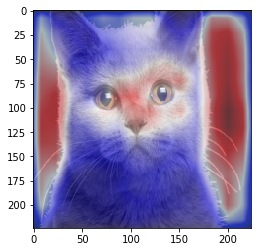

In [11]:
plt.imshow(catorig)
plt.imshow(preds[0,:,:,class2index['background']], cmap='seismic', alpha=0.5)